## This notebook consists of generating both static and temporal segment tolerances using only one of the five thermal maps recieved from L3 Harris Technologies.

### Importing necessary  python libraries, and PASTIS pre-built functions

In [1]:
import os
os.chdir("/Users/asahoo/repos/PASTIS")
import time
from shutil import copy
from astropy.io import fits
#import astropy.units as u
import hcipy
import numpy as np
import pastis.util as util    
from pastis.config import CONFIG_PASTIS 
from pastis.e2e_simulators.luvoir_imaging import LuvoirA_APLC 
#from pastis.e2e_simulators.generic_segmented_telescopes import SegmentedAPLC
import matplotlib.pyplot as plt
#import pandas as pd
#from scipy.interpolate import griddata
#import exoscene.image
import exoscene.star
#import exoscene.planet
#from exoscene.planet import Planet
from astropy.io import fits as pf

### Set some initial parameter or call them from config file

In [2]:
coronagraph_design = 'small'
nb_seg = CONFIG_PASTIS.getint('LUVOIR', 'nb_subapertures')
nm_aber = CONFIG_PASTIS.getfloat('LUVOIR', 'calibration_aberration') * 1e-9
sampling = CONFIG_PASTIS.getfloat('LUVOIR', 'sampling')

### Load thermal mode files from L3 Harris Technologies 

In [3]:
filepath = "/Users/asahoo/Documents/ultra/Sensitivities2.xlsx"
pad_orientation = np.pi/2*np.ones(nb_seg)

###  Define and create directory

In [4]:
data_dir = "/Users/asahoo/Desktop/data_repos/harris_data"
repo_dir = "/Users/asahoo/repos/PASTIS"
overall_dir = util.create_data_path(data_dir, telescope='luvoir_'+coronagraph_design)
resDir = os.path.join(overall_dir, 'matrix_numerical')

# Create necessary directories if they don't exist yet
os.makedirs(resDir, exist_ok=True)

/Users/asahoo/Desktop/data_repos/harris_data



### Instantiate LUVOIR-A

In [5]:
optics_input = os.path.join(util.find_repo_location(), CONFIG_PASTIS.get('LUVOIR', 'optics_path_in_repo'))
luvoir = LuvoirA_APLC(optics_input, coronagraph_design, sampling)

/opt/miniconda3/envs/pastis/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:74: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


### Create harris deformable mirror 

In [6]:
luvoir.create_segmented_harris_mirror(filepath,pad_orientation, thermal = True,mechanical=False,other=False)
luvoir.harris_sm #hcipy DM
n_harris = luvoir.harris_sm.num_actuators

### Flatten the DM

In [7]:
luvoir.harris_sm.flatten()

After applying a random actuator setting to 600 actuators i.e. (luvoir.harris_sm.random(1000)), (luvoir.harris_sm.phase)seems to work fine but Harris mode mirror phase called inside luvoir.calc_psf is not working

### Calculate the unaberrated coronagraphic PSF

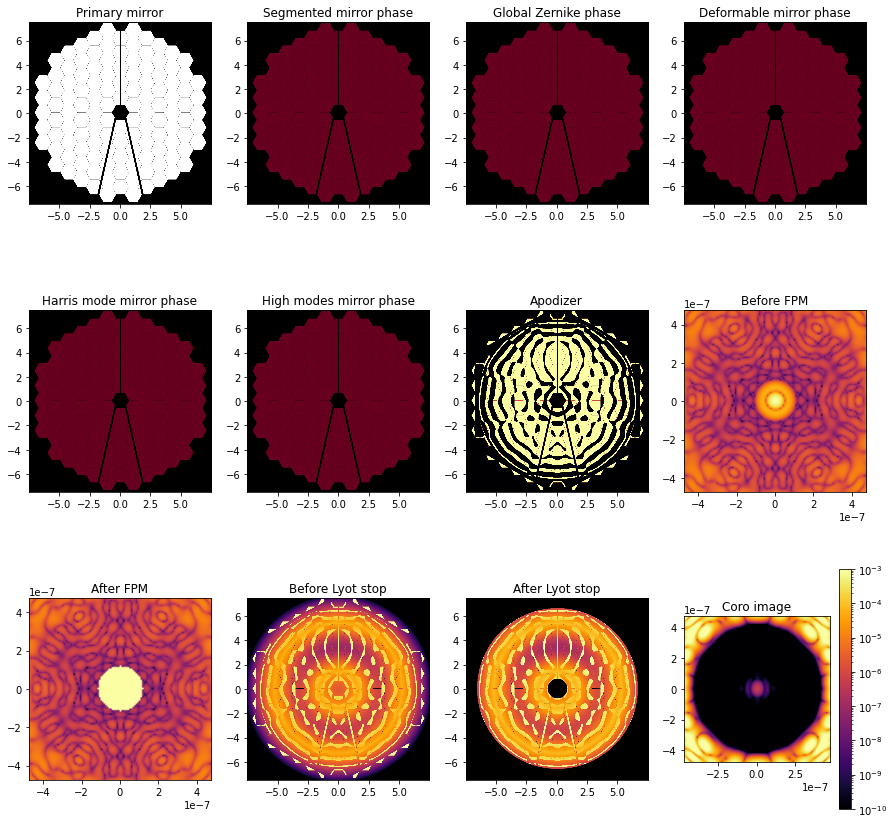

In [8]:
unaberrated_coro_psf, ref= luvoir.calc_psf(ref=True, display_intermediate=True, norm_one_photon=True)

### Calculate peak value of reference psf and static coronaraphic floor $c_{0}$

In [9]:
norm = np.max(ref)
dh_intensity = (unaberrated_coro_psf / norm) * luvoir.dh_mask
contrast_floor = np.mean(dh_intensity[np.where(luvoir.dh_mask != 0)])
print(f'norm: {norm}',f'constrast floor: {contrast_floor}')

norm: 0.010242195657579547 constrast floor: 4.237636070056418e-11


### Poking each segment with a thermal aberration and generating the subsequent electric field¶

In [10]:
nonaberrated_coro_psf, ref, efield = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield',norm_one_photon=True)
Efield_ref = nonaberrated_coro_psf.electric_field

In [11]:
print('Generating the E-fields for harris modes in science plane')
print(f'Calibration aberration used: {nm_aber} m')

start_time = time.time()
focus_fieldS = []
focus_fieldS_Re = []
focus_fieldS_Im = []

for i in range(0, 120):
    print(f'Working on "bulk" thermal mode, segment: {i+1}')
    
    # Apply calibration aberration to used mode
    harris_mode = np.zeros(n_harris)
    harris_mode[5*i] = (nm_aber)/2 
    luvoir.harris_sm.actuators  = harris_mode
   
    # Calculate coronagraphic E-field and add to lists
    aberrated_coro_psf, inter = luvoir.calc_psf(display_intermediate=False, return_intermediate='efield',norm_one_photon=True)
    focus_field1 = aberrated_coro_psf
    focus_fieldS.append(focus_field1)
    focus_fieldS_Re.append(focus_field1.real)
    focus_fieldS_Im.append(focus_field1.imag)

Generating the E-fields for harris modes in science plane
Calibration aberration used: 1e-09 m
Working on "bulk" thermal mode, segment: 1
Working on "bulk" thermal mode, segment: 2
Working on "bulk" thermal mode, segment: 3
Working on "bulk" thermal mode, segment: 4
Working on "bulk" thermal mode, segment: 5
Working on "bulk" thermal mode, segment: 6
Working on "bulk" thermal mode, segment: 7
Working on "bulk" thermal mode, segment: 8
Working on "bulk" thermal mode, segment: 9
Working on "bulk" thermal mode, segment: 10
Working on "bulk" thermal mode, segment: 11
Working on "bulk" thermal mode, segment: 12
Working on "bulk" thermal mode, segment: 13
Working on "bulk" thermal mode, segment: 14
Working on "bulk" thermal mode, segment: 15
Working on "bulk" thermal mode, segment: 16
Working on "bulk" thermal mode, segment: 17
Working on "bulk" thermal mode, segment: 18
Working on "bulk" thermal mode, segment: 19
Working on "bulk" thermal mode, segment: 20
Working on "bulk" thermal mode, se

### Taking a pair of poked efields to compute PASTIS matrix

In [12]:
mat_bulk = np.zeros([120, 120])
for i in range(0, 120):
    for j in range(0, 120):
        test = np.absolute((focus_fieldS[i].electric_field - Efield_ref) * np.conj(focus_fieldS[j].electric_field - Efield_ref))
        dh_test = (test / norm) * luvoir.dh_mask
        contrast = np.mean(dh_test[np.where(luvoir.dh_mask != 0)])
        mat_bulk[i, j] = contrast



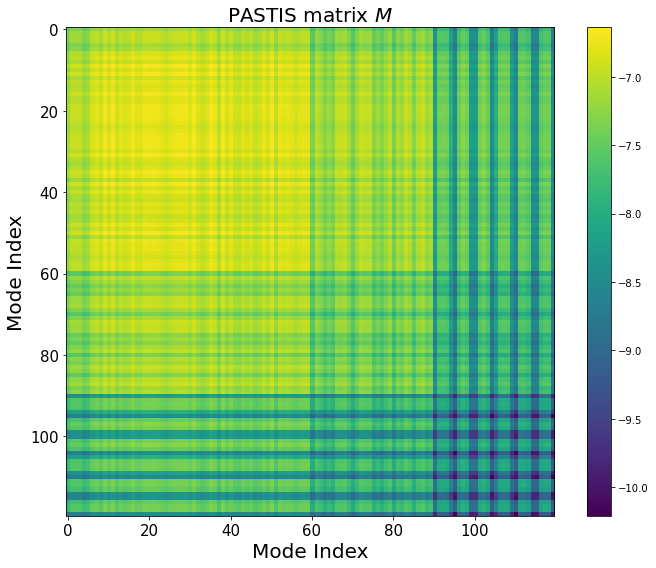

In [70]:
plt.figure(figsize=(10,8))
plt.imshow(np.log10(np.abs(mat_bulk)))
plt.title(r"PASTIS matrix $M$", fontsize=20)
plt.xlabel("Mode Index",fontsize=20)
plt.ylabel("Mode Index",fontsize=20)
plt.tick_params(labelsize=15)
# cbar = plt.colorbar(ticks = np.linspace(-13,-5,8,endpoint=False))
# cbar.ax.set_yticklabels([r'$10^{-13}$', r'$10^{-12}$', r'$10^{-11}$', r'$10^{-10}$', 
#                          r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$',r'$10^{-6}$'], fontsize=15)
# cbar.set_label(r"in units of $1/{nm^2}$",fontsize =15)
plt.colorbar()
plt.tight_layout()

###  saving pastis matrix, real and imaginary part of the electric field at the focus

In [14]:
filename_matrix1 = 'PASTISmatrix_n_harris_' + str(120)
hcipy.write_fits(mat_bulk, os.path.join(resDir, filename_matrix1 + '.fits'))
print('Matrix saved to:', os.path.join(resDir, filename_matrix1 + '.fits','\n'))

filename_matrix2 = 'EFIELD_Re_matrix_n_harris_' + str(120)
hcipy.write_fits(focus_fieldS_Re, os.path.join(resDir, filename_matrix2 + '.fits'))
print('Efield Real saved to:', os.path.join(resDir, filename_matrix2 + '.fits', '\n'))

filename_matrix3 = 'EFIELD_Im_matrix_n_harris_' + str(120)
hcipy.write_fits(focus_fieldS_Im, os.path.join(resDir, filename_matrix3 + '.fits'))
print('Efield Imag saved to:', os.path.join(resDir, filename_matrix3 + '.fits','\n'))

Matrix saved to: /Users/asahoo/Desktop/data_repos/harris_data/2022-03-10T15-42-59_luvoir_small/matrix_numerical/PASTISmatrix_n_harris_120.fits/

Efield Real saved to: /Users/asahoo/Desktop/data_repos/harris_data/2022-03-10T15-42-59_luvoir_small/matrix_numerical/EFIELD_Re_matrix_n_harris_120.fits/

Efield Imag saved to: /Users/asahoo/Desktop/data_repos/harris_data/2022-03-10T15-42-59_luvoir_small/matrix_numerical/EFIELD_Im_matrix_n_harris_120.fits/



### Calculate eigenvalues from the pastis matrix 

In [15]:
evals, evecs = np.linalg.eig(mat_bulk)
sorted_evals = np.sort(evals)
sorted_indices = np.argsort(evals)
sorted_evecs = evecs[:, sorted_indices]

### Set your target contrast 

In [16]:
c_target_log = -11
c_target = 10**(c_target_log)
#n_repeat = 20

### Compute per segment tolerances

In [17]:
mu_map_harris = np.sqrt(((c_target) / (120)) / (np.diag(mat_bulk)))

#np.savetxt('/Users/asahoo/Documents/ultra/report_11_01_21/mu_map.csv', mu_map_harris, delimiter=',')
#mu_map_harris = np.genfromtxt('/Users/asahoo/Desktop/data_repos/harris_data/mu_map.csv',delimiter=',')

Text(0.5, 0, 'Segment Number')

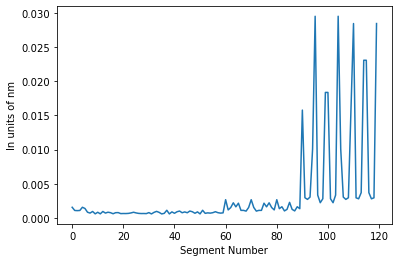

In [18]:
plt.plot(mu_map_harris)
plt.ylabel("In units of nm",fontsize=10)
plt.xlabel("Segment Number",fontsize=10)

## Temporal Analysis 

### Defining some input parameter required to only to run close loop contrast

In [19]:
z_pup_downsample = CONFIG_PASTIS.getfloat('numerical', 'z_pup_downsample') 
N_pup_z = int(luvoir.pupil_grid.shape[0] / z_pup_downsample) #N_pup_z = 100,used to define out-of-band efield
grid_zernike = hcipy.field.make_pupil_grid(N_pup_z, diameter=luvoir.diam)

npup = int(np.sqrt(luvoir.pupil_grid.x.shape[0]))
nimg = int(np.sqrt(luvoir.focal_det.x.shape[0]))

# Getting the flux together
sptype = 'A0V'
Vmag = 5.0
minlam = 500
maxlam = 600 
dark_current = 0     
CIC = 0            
star_flux = exoscene.star.bpgs_spectype_to_photonrate(spectype=sptype, Vmag=Vmag, minlam=minlam, maxlam=maxlam) #ph/s/m^2
Nph = star_flux.value*15**2*np.sum(luvoir.apodizer**2) / npup**2

The analytic form of Nph is not clear.

### Calculate the OBWFS and downsample OBWFS

In [20]:
luvoir.harris_sm.flatten()
nonaberrated_coro_psf ,refshit ,inter_ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield',norm_one_photon=True)
Efield_ref = nonaberrated_coro_psf.electric_field

In [21]:
luvoir.harris_sm.flatten()
harris_ref2 = luvoir.calc_out_of_band_wfs(norm_one_photon=True) #returns wavefront on obwfs detector
harris_ref2_sub_real = hcipy.field.subsample_field(harris_ref2.real, z_pup_downsample, grid_zernike, statistic='mean')
harris_ref2_sub_imag = hcipy.field.subsample_field(harris_ref2.imag, z_pup_downsample, grid_zernike, statistic='mean')
Efield_ref_OBWFS = (harris_ref2_sub_real + 1j*harris_ref2_sub_imag) * z_pup_downsample #why extra multiplicative factor?

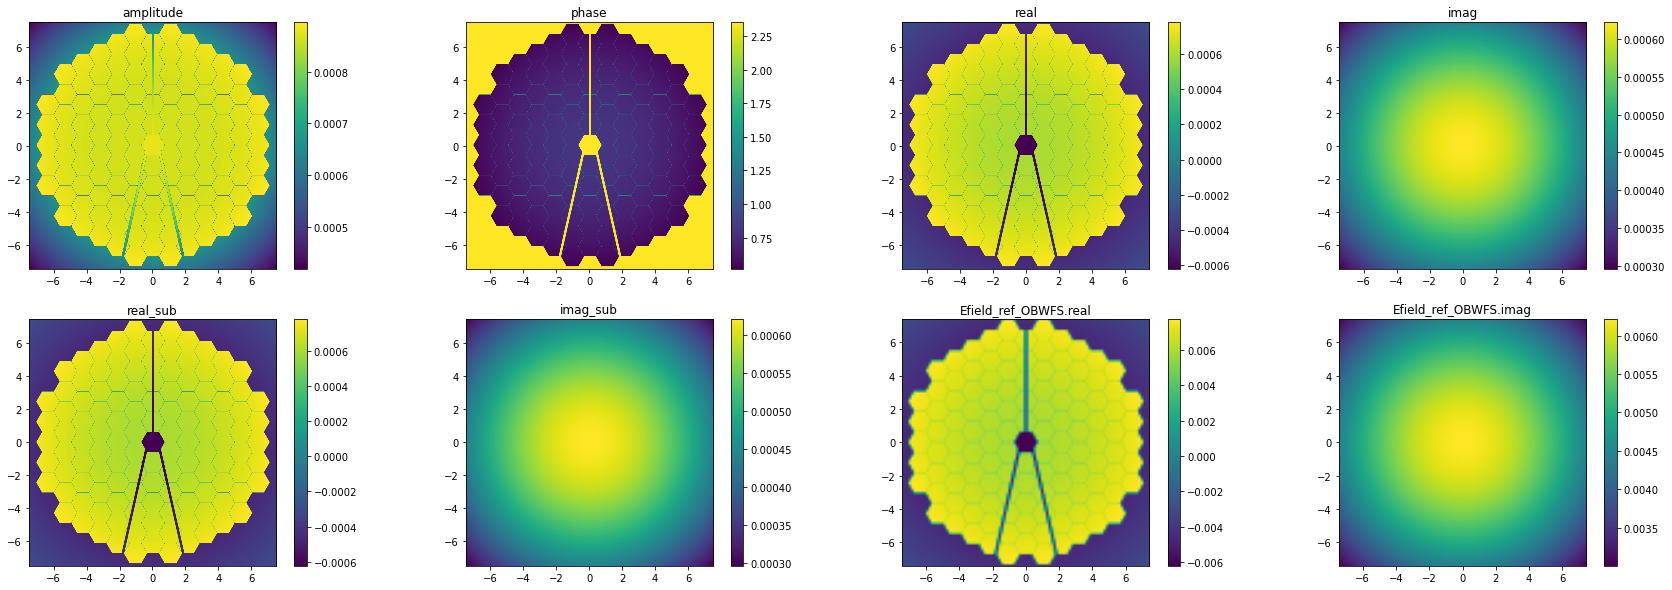

In [22]:
plt.figure(figsize=(30,10))

plt.subplot(2,4,1)
plt.title("amplitude")
hcipy.imshow_field(harris_ref2.amplitude)
plt.colorbar()

plt.subplot(2,4,2)
plt.title("phase")
hcipy.imshow_field(harris_ref2.phase)
plt.colorbar()

plt.subplot(2,4,3)
plt.title("real")
hcipy.imshow_field(harris_ref2.real)
plt.colorbar()

plt.subplot(2,4,4)
plt.title("imag")
hcipy.imshow_field(harris_ref2.imag)
plt.colorbar()

plt.subplot(2,4,5)
plt.title("real_sub")
hcipy.imshow_field(harris_ref2.real)
plt.colorbar()

plt.subplot(2,4,6)
plt.title("imag_sub")
hcipy.imshow_field(harris_ref2.imag)
plt.colorbar()

plt.subplot(2,4,7)
plt.title("Efield_ref_OBWFS.real")
hcipy.imshow_field(Efield_ref_OBWFS.real)
plt.colorbar()

plt.subplot(2,4,8)
plt.title("Efield_ref_OBWFS.imag")
hcipy.imshow_field(Efield_ref_OBWFS.imag)
plt.colorbar()
plt.show()

Play more with luvoir.calc_psf, and luvoir.calc_out_of_band_wfs

### Calcuating nyquist grids 

In [23]:
nyquist_sampling = 2.

# Actual grid for LUVOIR images
grid_test = hcipy.make_focal_grid(
            luvoir.sampling,
            luvoir.imlamD,
            pupil_diameter=luvoir.diam,
            focal_length=1,
            reference_wavelength=luvoir.wvln,
        ) 
#cartesiangrid

# Actual grid for LUVOIR images that are nyquist sampled
grid_det_subsample = hcipy.make_focal_grid(
            nyquist_sampling,
            np.floor(luvoir.imlamD),
            pupil_diameter=luvoir.diam,
            focal_length=1,
            reference_wavelength=luvoir.wvln,
        )
n_nyquist = int(np.sqrt(grid_det_subsample.x.shape[0]))

In [24]:
nyquist_sampling


2.0

n_nyquist? is grid_test necessary?

### Setting up nyquist sampled dark hole mask

In [25]:
design = 'small'

dh_outer_nyquist = hcipy.circular_aperture(2 * luvoir.apod_dict[design]['owa'] * luvoir.lam_over_d)(grid_det_subsample)
dh_inner_nyquist = hcipy.circular_aperture(2 * luvoir.apod_dict[design]['iwa'] * luvoir.lam_over_d)(grid_det_subsample)
dh_mask_nyquist = (dh_outer_nyquist - dh_inner_nyquist).astype('bool')

dh_size = len(np.where(luvoir.dh_mask != 0)[0])
dh_size_nyquist = len(np.where(dh_mask_nyquist != 0)[0])
dh_index = np.where(luvoir.dh_mask != 0)[0]
dh_index_nyquist = np.where(dh_mask_nyquist != 0)[0]

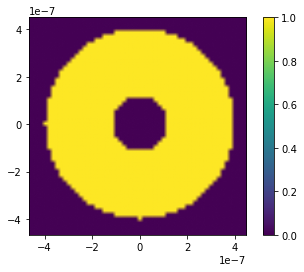

In [26]:
hcipy.imshow_field(dh_outer_nyquist - dh_inner_nyquist)
plt.colorbar()

### Defining reference electric field at obwfs plane. 

In [27]:
E0_OBWFS = np.zeros([N_pup_z*N_pup_z,1,2])
E0_OBWFS[:,0,0] = Efield_ref_OBWFS.real
E0_OBWFS[:,0,1] = Efield_ref_OBWFS.imag

### Defining coronagraphic refernce electric field at the focal plane

In [28]:
E0_coron = np.zeros([nimg*nimg,1,2])
E0_coron[:,0,0] = Efield_ref.real 
E0_coron[:,0,1] = Efield_ref.imag

### Defining coronagraphic efield which are nyquist_sampling

In [29]:
# E0_coron_nyquist = np.zeros([n_nyquist*n_nyquist,1,2])
# tmp0 = hcipy.interpolation.make_linear_interpolator_separated(Efield_ref, grid=grid_test)
# Efield_ref_nyquist = (luvoir.sampling/nyquist_sampling)**2*tmp0(grid_det_subsample)
# E0_coron_nyquist[:,0,0] = Efield_ref_nyquist.real
# E0_coron_nyquist[:,0,1] = Efield_ref_nyquist.imag

### Defining dark hole that is nyquist sampled, no where used in the code

In [30]:
# E0_coron_DH = np.zeros([dh_size,1,2])
# E0_coron_DH[:,0,0] = Efield_ref.real[dh_index]
# E0_coron_DH[:,0,1] = Efield_ref.imag[dh_index]
# E0_coron_DH_nyquist = np.zeros([dh_size_nyquist,1,2])
# E0_coron_DH_nyquist[:,0,0] = Efield_ref_nyquist.real[dh_index_nyquist]
# E0_coron_DH_nyquist[:,0,1] = Efield_ref_nyquist.real[dh_index_nyquist]

In [31]:
# plt.figure(figsize=(10,10))

# plt.subplot(2,2,1)
# plt.title("Efield_ref.real")
# plt.imshow(np.array(np.reshape((E0_OBWFS[:,0,0]),(100,100))))
# plt.colorbar()

# plt.subplot(2,2,2)
# plt.title("Efield_ref.imag")
# plt.imshow(np.array(np.reshape((E0_OBWFS[:,0,1]),(100,100))))
# plt.colorbar()

# plt.subplot(2,2,3)
# plt.title("coron_Efield_ref.real")
# plt.imshow(np.array(np.reshape((E0_coron[:,0,0]),(115,115))))
# plt.colorbar()

# plt.subplot(2,2,4)
# plt.title("coron_Efield_ref.imag")
# plt.imshow(np.array(np.reshape((E0_coron[:,0,1]),(115,115))))
# plt.colorbar()

# plt.subplot(2,3,5)
# plt.title("coron_Efield_ref_nyquist.real")
# plt.imshow(np.array(np.reshape((E0_coron_nyquist[:,0,0]),(56,56))))
# plt.colorbar()

# plt.subplot(2,3,6)
# plt.title("coron_Efield_ref_nyquist.imag")
# plt.imshow((np.array(np.reshape((E0_coron_nyquist[:,0,1]),(56,56)))))
# plt.colorbar()

### Defining Sensitvity matrix after coronagraph plane/ image plane??

In [32]:
filename_matrix2 = 'EFIELD_Re_matrix_n_harris_' + str(120) + '.fits'
G_harris_real = fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix2)) #120ndarray
filename_matrix3 = 'EFIELD_Im_matrix_n_harris_' + str(120) + '.fits'
G_harris_imag = fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix3)) #120ndarray

In [33]:
G_harris_real.shape

(120, 13225)

In [34]:
# G_coron_harris_nyquist= np.zeros([n_nyquist*n_nyquist,2, 120])
# for pp in range(0, 120):
#     tmp0 = G_harris_real[pp] + 1j*G_harris_imag[pp]
#     tmp1 = hcipy.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
#     tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp1(grid_det_subsample)
#     G_coron_harris_nyquist[:,0,pp] = tmp2.real - Efield_ref_nyquist.real
#     G_coron_harris_nyquist[:,1,pp] = tmp2.imag - Efield_ref_nyquist.imag #recheck?

In [35]:
# G_coron_harris_DH= np.zeros([dh_size,2,120])
# for pp in range(0, 120):
#     G_coron_harris_DH[:,0,pp] = G_harris_real[pp,dh_index] - Efield_ref.real[dh_index]
#     G_coron_harris_DH[:,1,pp] = G_harris_imag[pp,dh_index] - Efield_ref.imag[dh_index]

In [36]:
# G_coron_harris_DH_nyquist= np.zeros([dh_size_nyquist,2,120])
# for pp in range(0, 120):
#     tmp0 = G_harris_real[pp] + 1j*G_harris_imag[pp]
#     tmp1 = hcipy.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
#     tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp1(grid_det_subsample)
#     G_coron_harris_DH_nyquist[:,0,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.real[dh_index_nyquist]
#     G_coron_harris_DH_nyquist[:,1,pp-1] = tmp2.imag[dh_index_nyquist] - Efield_ref_nyquist.imag[dh_index_nyquist]

In [37]:
G_coron_harris= np.zeros([nimg*nimg,2,120])
for pp in range(0, 120):
    G_coron_harris[:,0,pp] = G_harris_real[pp] - Efield_ref.real
    G_coron_harris[:,1,pp] = G_harris_imag[pp] - Efield_ref.imag

### Calculating out of band sensitvity matrix or G_OBWFS

In [38]:
start_time = time.time()
focus_fieldS = []
focus_fieldS_Re = []
focus_fieldS_Im = []

for i in range(0, 120):
    print(f'Working on "bulk" thermal mode, segment: {i+1}')
    
    # Apply calibration aberration to used mode
    harris_mode = np.zeros(n_harris)
    harris_mode[5*i] = (nm_aber)/2 
    luvoir.harris_sm.actuators  = harris_mode
    harris_meas = luvoir.calc_out_of_band_wfs(norm_one_photon=True) #returns wavefront on obwfs detector
    harris_meas_sub_real = hcipy.field.subsample_field(harris_meas.real, z_pup_downsample, grid_zernike, statistic='mean')
    harris_meas_sub_imag = hcipy.field.subsample_field(harris_meas.imag, z_pup_downsample, grid_zernike, statistic='mean')
    focus_field1 = harris_meas_sub_real + 1j * harris_meas_sub_imag
    focus_fieldS.append(focus_field1)
    focus_fieldS_Re.append(focus_field1.real)
    focus_fieldS_Im.append(focus_field1.imag)

Working on "bulk" thermal mode, segment: 1
Working on "bulk" thermal mode, segment: 2
Working on "bulk" thermal mode, segment: 3
Working on "bulk" thermal mode, segment: 4
Working on "bulk" thermal mode, segment: 5
Working on "bulk" thermal mode, segment: 6
Working on "bulk" thermal mode, segment: 7
Working on "bulk" thermal mode, segment: 8
Working on "bulk" thermal mode, segment: 9
Working on "bulk" thermal mode, segment: 10
Working on "bulk" thermal mode, segment: 11
Working on "bulk" thermal mode, segment: 12
Working on "bulk" thermal mode, segment: 13
Working on "bulk" thermal mode, segment: 14
Working on "bulk" thermal mode, segment: 15
Working on "bulk" thermal mode, segment: 16
Working on "bulk" thermal mode, segment: 17
Working on "bulk" thermal mode, segment: 18
Working on "bulk" thermal mode, segment: 19
Working on "bulk" thermal mode, segment: 20
Working on "bulk" thermal mode, segment: 21
Working on "bulk" thermal mode, segment: 22
Working on "bulk" thermal mode, segment: 

In [39]:
filename_matrix = 'EFIELD_OBWFS_Re_matrix_num_harris_' + str(120)
hcipy.write_fits(focus_fieldS_Re, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Real saved to:', os.path.join(resDir, filename_matrix + '.fits'))

filename_matrix = 'EFIELD_OBWFS_Im_matrix_num_harris_' + str(120)
hcipy.write_fits(focus_fieldS_Im, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Imag saved to:', os.path.join(resDir, filename_matrix + '.fits'))

Efield Real saved to: /Users/asahoo/Desktop/data_repos/harris_data/2022-03-10T15-42-59_luvoir_small/matrix_numerical/EFIELD_OBWFS_Re_matrix_num_harris_120.fits
Efield Imag saved to: /Users/asahoo/Desktop/data_repos/harris_data/2022-03-10T15-42-59_luvoir_small/matrix_numerical/EFIELD_OBWFS_Im_matrix_num_harris_120.fits


In [40]:
filename_matrix = 'EFIELD_OBWFS_Re_matrix_num_harris_' + str(120)+'.fits'
G_OBWFS_real = fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix))
filename_matrix = 'EFIELD_OBWFS_Im_matrix_num_harris_' + str(120)+'.fits'
G_OBWFS_imag =  fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix))

In [41]:
G_OBWFS= np.zeros([N_pup_z*N_pup_z,2,120])
for pp in range(0, 120):
    G_OBWFS[:,0,pp] = G_OBWFS_real[pp]*z_pup_downsample - Efield_ref_OBWFS.real
    G_OBWFS[:,1,pp] = G_OBWFS_imag[pp]*z_pup_downsample - Efield_ref_OBWFS.imag

###  close loop batch estimation algorithm

In [42]:
def req_closedloop_calc_batch(Gcoro, Gsensor, E0coro, E0sensor, Dcoro, Dsensor, t_exp, flux, Q, Niter, dh_mask, norm):
    P = np.zeros(Q.shape)  # WFE modes covariance estimate
    r = Gsensor.shape[2]
    N = Gsensor.shape[0]
    N_img = Gcoro.shape[0]
    c = 1
    # Iterations of ALGORITHM 1
    contrast_hist = np.zeros(Niter)
    intensity_WFS_hist = np.zeros(Niter)
    cal_I_hist = np.zeros(Niter)
    eps_hist = np.zeros([Niter, r])
    averaged_hist = np.zeros(Niter)
    contrasts = []
    for pp in range(Niter):
        eps = np.random.multivariate_normal(np.zeros(r), P + Q * t_exp).reshape((1, 1, r))  # random modes
        G_eps = np.sum(Gsensor * eps, axis=2).reshape((N, 1, 2 * c)) + E0sensor  # electric field
        G_eps_squared = np.sum(G_eps * G_eps, axis=2, keepdims=True)
        G_eps_G = np.matmul(G_eps, Gsensor)
        G_eps_G_scaled = G_eps_G / np.sqrt(G_eps_squared + Dsensor / flux / t_exp)  # trick to save RAM
        cal_I = 4 * flux * t_exp * np.einsum("ijk,ijl->kl", G_eps_G_scaled, G_eps_G_scaled)  # information matrix
        #         P = np.linalg.inv(np.linalg.inv(P+Q*t_exp/2) + cal_I)
        P = np.linalg.pinv(cal_I)

        # Coronagraph
        G_eps_coron = np.sum(Gcoro * eps, axis=2).reshape((N_img, 1, 2 * c)) + E0coro
        G_eps_coron_squared = np.sum(G_eps_coron * G_eps_coron, axis=2, keepdims=True)
        intensity = G_eps_coron_squared * flux * t_exp + Dcoro

        # Wavefront sensor
        intensity_WFS = G_eps_squared * flux * t_exp + Dsensor

        # Archive
        test_DH0 = intensity[:, 0, 0] * luvoir.dh_mask
        test_DH = np.mean(test_DH0[np.where(test_DH0 != 0)])
        contrasts.append(test_DH / flux / t_exp / norm)
        intensity_WFS_hist[pp] = np.sum(intensity_WFS) / flux
        cal_I_hist[pp] = np.mean(cal_I) / flux
        eps_hist[pp] = eps
        averaged_hist[pp] = np.mean(contrasts)
    #         print("est. contrast", np.mean(contrasts))
    #         print("est. contrast", np.mean(contrasts))

    outputs = {'intensity_WFS_hist': intensity_WFS_hist,
               'cal_I_hist': cal_I_hist,
               'eps_hist': eps_hist,
               'averaged_hist': averaged_hist,
               'contrasts': contrasts}

    return outputs


In [43]:
flux = Nph
Qharris = np.diag(np.asarray(mu_map_harris**2))

Ntimes = 20
TimeMinus = -2
TimePlus = 5.5 #3.5
Nwavescale = 8
#WaveScaleMinus = -2
#WaveScalePlus = 1
Nflux = 3
#fluxPlus = 10
#fluxMinus = 0

#timeVec = np.logspace(TimeMinus,TimePlus,Ntimes)
#WaveVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)
#fluxVec = np.linspace(fluxMinus,fluxPlus,Nflux)
#wavescaleVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)

In [44]:
Qharris.shape

(120, 120)

In [45]:
P_0 = np.zeros(Qharris.shape)
r_0 = G_OBWFS.shape[2]
N_0 = G_OBWFS.shape[0]
N_img_0 = G_coron_harris.shape[0]
c_0 = 1

niter_0 = 10
t_exp = 10 #in seconds

In [46]:
# eps_0 = np.random.multivariate_normal(np.zeros(r_0), P_0 + Qharris * t_exp).reshape((1, 1, r_0))
# G_eps_0 = np.sum(G_OBWFS * eps_0, axis=2).reshape((N_0, 1, 2 * c_0)) + E0_OBWFS
# G_eps_squared_0 = np.sum(G_eps_0 * G_eps_0, axis=2, keepdims=True)

# g2 = (G_eps_0 * G_eps_0)
# g2_2 = (np.array(np.reshape(g2[:,0,0], (100,100)))) + (np.array(np.reshape(g2[:,0,1], (100,100))))
# g2_2_ressidue = g2_2 - (np.array(np.reshape(G_eps_squared_0[:,0,0], (100,100)))) 

In [47]:
#plt.plot(np.random.multivariate_normal(np.zeros(r_0), P_0 + Qharris * t_exp))

In [48]:
# plt.figure(figsize=(20,10))

# plt.subplot(2,3,1)
# plt.title("G_eps_0[:,0,0]")
# plt.imshow((np.array(np.reshape(G_eps_0[:,0,0], (100,100)))))
# plt.colorbar()

# plt.subplot(2,3,2)
# plt.title("G_eps_0[:,0,1]")
# plt.imshow((np.array(np.reshape(G_eps_0[:,0,1], (100,100)))))
# plt.colorbar()

# plt.subplot(2,3,3)
# plt.title("g2[:,0,0]")
# plt.imshow((np.array(np.reshape(g2[:,0,0], (100,100)))))
# plt.colorbar()

# plt.subplot(2,3,4)
# plt.title("g2[:,0,1]")
# plt.imshow((np.array(np.reshape(g2[:,0,1], (100,100)))))
# plt.colorbar()

# plt.subplot(2,3,5)
# plt.title("G_eps_squared_0[:,0,0]")
# plt.imshow((np.array(np.reshape(G_eps_squared_0[:,0,0], (100,100)))))
# plt.colorbar()

# plt.subplot(2,3,6)
# plt.title("G_eps_G_0 [:,0,19]")
# plt.imshow((np.array(np.reshape(G_eps_G_0 [:,0,19], (100,100)))))
# plt.colorbar()

In [49]:
# plt.figure()
# plt.title("g2_2 - G_eps_squared_0[:,0,0]")
# plt.imshow(g2_2_ressidue)
# plt.colorbar()                                                      

In [50]:
# G_eps_G_0 = np.matmul(G_eps_0, G_OBWFS)

# query1 = (np.array(np.reshape(G_eps_0[:,0,0], (100,100)))) * (np.array(np.reshape(G_OBWFS[:,0,19], (100,100)))) 
# query2 = (np.array(np.reshape(G_eps_0[:,0,1], (100,100)))) * (np.array(np.reshape(G_OBWFS[:,1,19], (100,100))))
# query = query1 + query2

In [51]:
# plt.figure(figsize=(30,10))

# plt.subplot(2,3,1)
# plt.title("G_eps_0[:,0,0]")
# plt.imshow((np.array(np.reshape(G_eps_0[:,0,0], (100,100)))))
# plt.colorbar()

# plt.subplot(2,3,2)
# plt.title("G_eps_0[:,0,1]")
# plt.imshow((np.array(np.reshape(G_eps_0[:,0,1], (100,100)))))
# plt.colorbar()

# plt.subplot(2,3,3)
# plt.title("G_OBWFS[:,1,19]")
# plt.imshow((np.array(np.reshape(G_OBWFS[:,1,19], (100,100)))))
# plt.colorbar()

# plt.subplot(2,3,4)
# plt.title("G_eps_G_0[:,0,19]")
# plt.imshow((np.array(np.reshape(G_eps_G_0[:,0,19], (100,100)))))
# plt.colorbar()

# plt.subplot(2,3,5)
# plt.title("query")
# plt.imshow(query)
# plt.colorbar()

# plt.subplot(2,3,6)
# plt.title("residue")
# plt.imshow((np.array(np.reshape(G_eps_G_0[:,0,19], (100,100))))-query)
# plt.colorbar()

In [52]:
# StarMag = 0.0
# Starfactor = 10**(-StarMag/2.5)
# G_eps_G_scaled_0 = G_eps_G_0 / np.sqrt(G_eps_squared_0 + G_OBWFS / (flux*Starfactor) / t_exp)

In [53]:
#np.sqrt(G_eps_squared_0 + G_OBWFS / (flux*Starfactor) / t_exp).shape

In [54]:
# plt.figure(figsize=(15,5))

# plt.subplot(1,3,1)
# plt.title("G_eps_G_0[:,0,19]")
# plt.imshow((np.array(np.reshape(G_eps_G_0[:,0,19], (100,100)))))
# plt.colorbar()

# plt.subplot(1,3,2)
# plt.title("G_eps_G_scaled_0[:,0,19]")
# plt.imshow((np.array(np.reshape(G_eps_G_scaled_0[:,0,19], (100,100)))))
# plt.colorbar()



In [55]:
#G_eps_G_scaled_0.shape

In [56]:
#fish_I = np.einsum("ijk,ijl->kl",G_eps_G_scaled_0, G_eps_G_scaled_0) #"ijk,ijl->kl"

In [57]:
#fish_I.shape

In [58]:
# plt.figure(figsize=(10,10))

# plt.subplot(2,2,1)
# plt.title("E0_OBWFS[:,0,0]")
# plt.imshow((np.array(np.reshape(G_eps_0[:,0,0], (100,100)))))
# plt.colorbar()

# plt.subplot(2,2,2)
# plt.title("E0_OBWFS[:,0,1]")
# plt.imshow((np.array(np.reshape(G_eps_0[:,0,1], (100,100)))))
# plt.colorbar()

# plt.subplot(2,2,3)
# plt.title("G_OBWFS[:,1,19]")
# plt.imshow((np.array(np.reshape(G_OBWFS[:,1,19], (100,100)))))
# plt.colorbar()

# plt.subplot(2,2,4)
# plt.title("G_OBWFS[:,0,19]")
# plt.imshow((np.array(np.reshape(G_OBWFS[:,0,19], (100,100)))))
# plt.colorbar()


In [59]:
# a = np.arange(8).reshape(2,2,2) 
# b = np.arange(4).reshape(2,2)


In [60]:
#print (np.matmul(b,a))

In [61]:
# a = np.arange(8).reshape(2,2,2) 
# print(a)

In [62]:
#cal_a = np.einsum("ijk,ijl->kl",a,a)

In [63]:
#(cal_a)

In [64]:
res = np.zeros([Ntimes, Nwavescale, Nflux, 1])
result_wf_test =[]

#i=-1
for wavescale in range (1,15,2):
    #i=i+1
    print('Harris modes with batch OBWFS and noise %f'% wavescale, "i",i)  
    niter = 10
    timer1 = time.time()
    StarMag = 0.0
    #j=-1
    for tscale in np.logspace(TimeMinus, TimePlus, Ntimes):
        j=j+1
        Starfactor = 10**(-StarMag/2.5)
        print(tscale)
        tmp0 = req_closedloop_calc_batch(G_coron_harris, G_OBWFS, E0_coron, E0_OBWFS, dark_current+CIC/tscale,
                                                 dark_current+CIC/tscale, tscale, flux*Starfactor, 0.0001*wavescale**2*Qharris,
                                                 niter, luvoir.dh_mask, norm)    
        tmp1 = tmp0['averaged_hist']
        n_tmp1 = len(tmp1)
        result_wf_test.append(tmp1[n_tmp1-1])


Harris modes with batch OBWFS and noise 1.000000 i 119
0.01
0.024816289228368264
0.06158482110660264
0.15283067326587688
0.37926901907322497
0.941204967268067
2.3357214690901213
5.7963939533849675
14.38449888287663
35.69698846826066
88.58667904100832
219.8392648862289
545.5594781168514
1353.8761800225445
3359.818286283781
8337.8222347179
20691.3808111479
51348.32907437549
127427.49857031347
316227.7660168379
Harris modes with batch OBWFS and noise 3.000000 i 119
0.01
0.024816289228368264
0.06158482110660264
0.15283067326587688
0.37926901907322497
0.941204967268067
2.3357214690901213
5.7963939533849675
14.38449888287663
35.69698846826066
88.58667904100832
219.8392648862289
545.5594781168514
1353.8761800225445
3359.818286283781
8337.8222347179
20691.3808111479
51348.32907437549
127427.49857031347
316227.7660168379
Harris modes with batch OBWFS and noise 5.000000 i 119
0.01
0.024816289228368264
0.06158482110660264
0.15283067326587688
0.37926901907322497
0.941204967268067
2.335721469090121

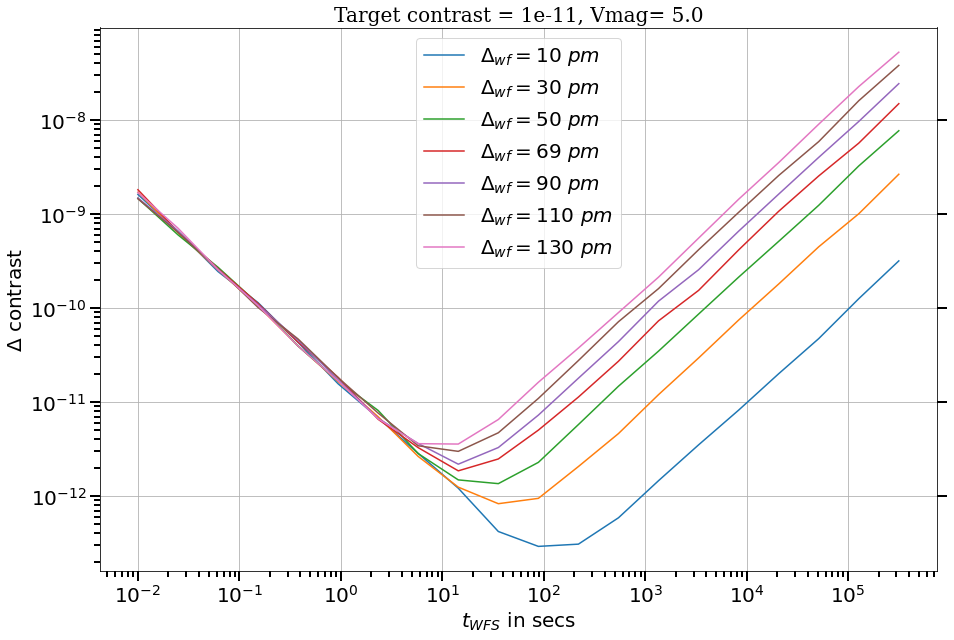

In [69]:
delta_wf = []
for wavescale in range (1,15,2):
    wf = 1e3*np.sqrt(0.0001*wavescale**2)
    delta_wf.append(wf)

texp = np.logspace(TimeMinus, TimePlus, Ntimes)

font = {'family': 'serif','color' : 'black','weight': 'normal','size'  :  20}
plt.figure(figsize =(15,10))

plt.title('Target contrast = %s, Vmag= %s'%(c_target, Vmag),fontdict=font)
plt.plot(texp,result_wf_test[0:20]-contrast_floor, label=r'$\Delta_{wf}= %d\ pm$'%(delta_wf[0]))
plt.plot(texp,result_wf_test[20:40]-contrast_floor, label=r'$\Delta_{wf}=%d\ pm$'%(delta_wf[1]))
plt.plot(texp,result_wf_test[40:60]-contrast_floor, label=r'$\Delta_{wf}=%d\ pm$'%(delta_wf[2]))
plt.plot(texp,result_wf_test[60:80]-contrast_floor, label=r'$\Delta_{wf}=%d\ pm$'%(delta_wf[3]))
plt.plot(texp,result_wf_test[80:100]-contrast_floor, label=r'$\Delta_{wf}=%d\ pm$'%(delta_wf[4]))
plt.plot(texp,result_wf_test[100:120]-contrast_floor, label=r'$\Delta_{wf}=%d\ pm$'%(delta_wf[5]))
plt.plot(texp,result_wf_test[120:140]-contrast_floor, label=r'$\Delta_{wf}=%d\ pm$'%(delta_wf[6]))
plt.xlabel("$t_{WFS}$ in secs",fontsize=20)
plt.ylabel("$\Delta$ contrast",fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc = 'upper center',fontsize=20)
plt.tick_params(top=False, bottom=True, left=True, 
                right=True,labelleft=True, labelbottom=True,
                labelsize=20)
plt.tick_params(axis='both',which='major',length=10, width=2)
plt.tick_params(axis='both',which='minor',length=6, width=2)
plt.grid()
plt.savefig('/Users/asahoo/Documents/ultra/temp_plots/bulk2_cont_wf_absM.png')
plt.show()

### Codeblock to generate .gif file

In [66]:
# for i in range(0, 120):
#     print(f'Working on "bulk" thermal mode, segment: {i+1}')
    
#     # Apply calibration aberration to used mode
#     harris_mode = np.zeros(n_harris)
#     harris_mode[i*5] = (nm_aber)/2 
#     luvoir.harris_sm.actuators  = harris_mode
    
#     plt.figure()
#     plt.text(9.6, 7.6, 'm', fontsize = 10)
#     hcipy.imshow_field(luvoir.harris_sm.surface, mask=luvoir.aperture, cmap='RdBu')
#     cbar = plt.colorbar()
#     plt.tight_layout()
#     #plt.savefig('/Users/asahoo/Documents/ultra/temp_plots/bulk_2_2_22/poke_%d.png'% i, dpi=165)
#     plt.savefig('/Users/asahoo/Documents/ultra/temp_plots/bulk_2_2_22/poke_{0:03}.png'.format(i), dpi=165)
    

In [67]:
# from PIL import Image
# import glob
# os.chdir("/Users/asahoo/Documents/ultra/temp_plots/bulk_2_2_22/")

# imgs = glob.glob("/Users/asahoo/Documents/ultra/temp_plots/bulk_2_2_22/*.png")
# imgs.sort()

# for i in imgs:
#     new_frame = Image.open(i)
#     frames.append(new_frame)
 
# # Save into a GIF file that loops forever
# frames[0].save('bulk.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)